In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import fsolve, curve_fit
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp

# CPN Project Task A

## Group 7

- Marco Arnold
- Hein Boonstra
- David Bender
- Lourens Olivier
- Matthew Strauss


## Task 2 – System Identification:

| System Variable         | Assigned Variable        |
|-------------------------|--------------------------|
| (1) Manipulated variable | Flow rate to reactor      |
| (2) Control variable     | Production rate of ammonia|
| (3) Disturbance variable | Feed Composition          |
| (4) Final control element| Valve                     |

Reasons for assigning System variable (1)-(4):
1. It can be easily controlled by adjusting the position of the valve.
2. We are told to produce high volumes of ammonia no matter what. 
3. The boss has told us the feed composition can vary and this is a disturbance. 
4. By adjusting the valve, the flowrate to the reactor (manipulated variable) changes. 

## Task 3 – System Equations and Assumptions:

### Assumptions

#### Conservative Equations

\begin{aligned}
\frac{dy(t)}{dt} &= \frac{K_p P s(t)}{\tau^2} - \frac{2 \zeta y(t)}{\tau} - \frac{x(t)}{\tau^2} &...(1) \\
\frac{dx(t)}{dt} &= y(t) &...(2) \\
\frac{dC_{NH_3}}{dt} &= \frac{FC_{NH3,in}}{V} - \frac{FC_{NH3}}{V} + 2kC_{N_2}C_{H_2}^3 &...(3)\\
\frac{dC_{H_2}}{dt} &= \frac{FC_{H2,in}}{V} - \frac{FC_{H2}}{V} - 3kC_{N_2}C_{H_2}^3 &...(4)\\
\frac{dC_{N_2}}{dt} &= \frac{FC_{N2,in}}{V} - \frac{FC_{N2}}{V} - kC_{N_2}C_{H_2}^3 &...(5)\\
\end{aligned}

#### Constitutive equations
\begin{aligned}
F &= C_{cv} f(x(t))\sqrt{\frac{\Delta P_{CV}}{SG}} &...(6)\\
f(x(t)) &= \sqrt{x(t)} &...(7)\\
k &= k_0 e^{-\frac{E_a}{RT}} &...(8)
\end{aligned}



## Task 4 – Steady State Calculations Using Python:

In [2]:
#-----------------------------------Calculating volumetric flow----------------------------------------------
MM = np.array([14.0067*2, 1.00784*2])
molar_fractions = np.array([0.25, 0.75])
MM_mix = MM[0]*molar_fractions[0] + MM[1]*molar_fractions[1]   #g/mol
molar_flow = 1304.85    #mol/s from Task 1
mass_flow = molar_flow*MM_mix / 1000   #kg/s
density_mix = 8.81609     #kg/m^3 from Task 1
volumetric_flow = mass_flow/density_mix #m^3/s
#------------------------------------------Given variables------------------------------------------------------
V = 1
k0 = 0.0001
Ea = 60000
R = 8.314
T = 866.85+273.15   #K from Task 1
k = k0*np.exp(-Ea/(R*T))
F = volumetric_flow
CN2_in = molar_flow * molar_fractions[0] / F
CH2_in = molar_flow * molar_fractions[1] / F
CNH3_in = 0
#------------------------------------------Using fsolve------------------------------------------------------
def solve(y):
    CN2, CH2, CNH3 = y
    eqn1 = F*CN2_in/V - F*CN2/V - k*CN2*CH2**3
    eqn2 = F*CH2_in/V - F*CH2/V - 3*k*CN2*CH2**3
    eqn3 = F*CNH3_in/V - F*CNH3/V + 2*k*CN2*CH2**3
    return eqn1, eqn2, eqn3
guess = [CN2_in/2, CH2_in/2, CN2_in*2]
CN2_ss, CH2_ss, CNH3_ss = fsolve(solve,guess)

### The results of the above calculations are given in the table below 


| Variable              | Value   | Units    |
|-----------------------|---------|----------|
| Concentration of N2   | 82.454  | mol/m³   |
| Concentration of H2   | 247.363 | mol/m³   |
| Concentration of NH3  | 352.764 | mol/m³   |
| Flow rate             | 1.260   | m³/s     |

## Task 5 – Steady State Simulation Using DWSIM:

## Task 6 – Transient System Response:

In [31]:
#------------------------------------------Known variables------------------------------------------------------
tau = 10   #s
Kp = 1/12
zeta = 3
P_initial = 9
del_P = 2
#----------------------------------------Initial calculations---------------------------------------------------
x_initial = Kp*P_initial
SG = density_mix / 997
Cv = volumetric_flow / np.sqrt(x_initial) / np.sqrt(2/SG)
#--------------------------Solver function-----------------------------------------------------
def euler_solver(t_end, steps, t_change):
#------------------------------------------Initialize values----------------------------------------------------    
    times = np.linspace(0, t_end, steps)
    dt = times[1] - times[0]
    Ps = np.zeros(len(times))
    x = np.zeros(len(times))
    y = np.zeros(len(times))
    CN2 = np.zeros(len(times))
    CH2 = np.zeros(len(times))
    CNH3 = np.zeros(len(times))
    x[0] = x_initial
    y[0] = 0
    CN2[0] = CN2_ss
    CH2[0] = CH2_ss
    CNH3[0] = CNH3_ss
#-------------------------------------------For loop 1----------------------------------------------------------   
    for i in range(0, len(times)):
#----------------------------------Get pressures with step change-----------------------------------------------        
        if times[i] <= t_change:
            Ps[i] = P_initial
        else:
            Ps[i] = P_initial + del_P
#-------------------------------------------For loop 2---------------------------------------------------------
    for j in range(0, len(Ps)-1):
#-----------------------------------------Solve for x values---------------------------------------------------           
        dxdt = y[j]
        dydt = -2*zeta/tau*dxdt - x[j]/tau**2 + Kp*Ps[j]/tau**2 
        x[j+1] = x[j] + dxdt*dt
        y[j+1] = y[j] + dydt*dt
#----------------------------------------Calculating flowrate--------------------------------------------------
    Fs = Cv * x**0.5 * np.sqrt(2/SG)
#-------------------------------------------For loop 3---------------------------------------------------------
    for p in range(0, len(times)-1):
#--------------------------------------Solve for concentrations------------------------------------------------
        dcn2dt = Fs[p]*(CN2_in - CN2[p]) - k*CN2[p]*CH2[p]**3
        dch2dt = Fs[p]*(CH2_in - CH2[p]) - 3*k*CN2[p]*CH2[p]**3
        dcnh3dt = Fs[p]*(CNH3_in - CNH3[p]) + 2*k*CN2[p]*CH2[p]**3
        CN2[p+1] = CN2[p] + dcn2dt*dt
        CH2[p+1] = CH2[p] + dch2dt*dt
        CNH3[p+1] = CNH3[p] + dcnh3dt*dt
    
    return times, Ps, x, Fs, CN2, CH2, CNH3

times, Ps, x, Fs, CN2, CH2, CNH3 = euler_solver(400, 10000, 50)

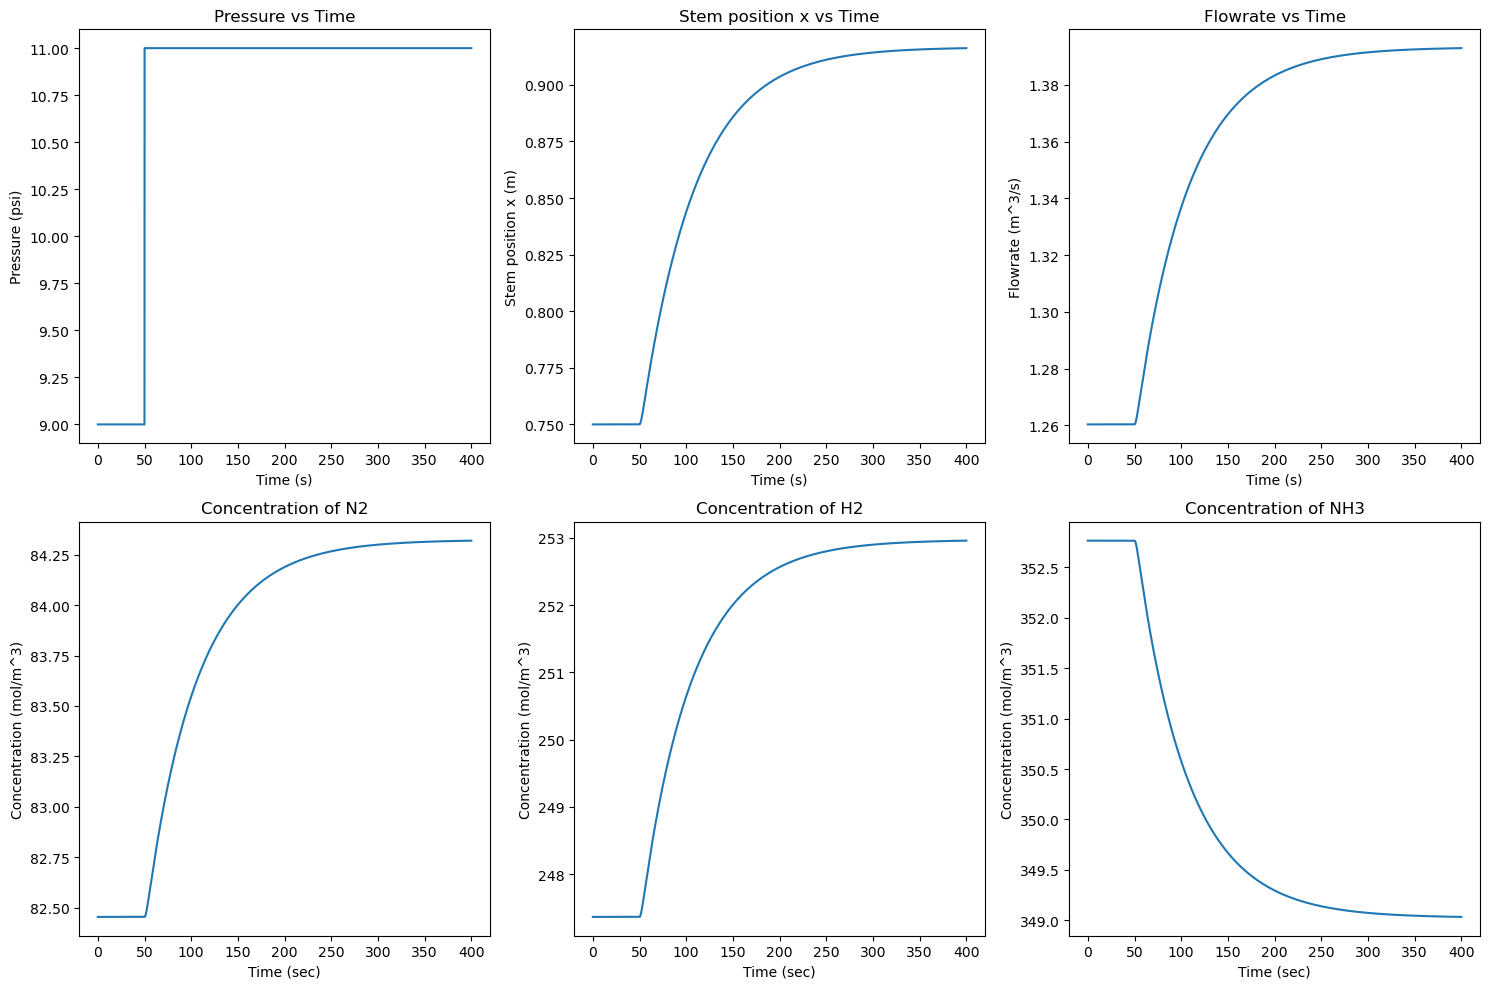

In [32]:
#----------------------------------------Plotting the results--------------------------------------------------
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

axs[0, 0].plot(times, Ps)
axs[0, 0].set_title("Pressure vs Time")
axs[0, 0].set_xlabel("Time (s)")
axs[0, 0].set_ylabel("Pressure (psi)")
axs[0, 1].plot(times, x)
axs[0, 1].set_title("Stem position x vs Time")
axs[0, 1].set_xlabel("Time (s)")
axs[0, 1].set_ylabel("Stem position x (m)")
axs[0, 2].plot(times, Fs)
axs[0, 2].set_title("Flowrate vs Time")
axs[0, 2].set_xlabel("Time (s)")
axs[0, 2].set_ylabel("Flowrate (m^3/s)")
axs[1, 0].plot(times, CN2)
axs[1, 0].set_title("Concentration of N2")
axs[1, 0].set_xlabel("Time (sec)")
axs[1, 0].set_ylabel("Concentration (mol/m^3)")
axs[1, 1].plot(times, CH2)
axs[1, 1].set_title("Concentration of H2")
axs[1, 1].set_xlabel("Time (sec)")
axs[1, 1].set_ylabel("Concentration (mol/m^3)")
axs[1, 2].plot(times, CNH3)
axs[1, 2].set_title("Concentration of NH3")
axs[1, 2].set_xlabel("Time (sec)")
axs[1, 2].set_ylabel("Concentration (mol/m^3)")

plt.tight_layout()
plt.show()

## Task 7 – FOPDT Fitting and Determination of Kp, Tau and Theta: